### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [158]:
import pandas as pd

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [159]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000
mean,0.883279,761.545781,54.277552,209.982070,215.797343,62.086895
std,0.833093,1151.855864,56.299433,198.147531,272.329634,48.291224
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000
25%,-0.000000,153.000000,15.000000,80.000000,49.965000,27.682500
50%,0.693147,356.000000,34.000000,150.000000,118.950000,49.785000
75%,1.386294,886.500000,74.000000,268.000000,266.235000,84.280000
max,3.550250,13162.000000,315.000000,1440.000000,2464.840000,318.190000


### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

<AxesSubplot:ylabel='Frequency'>

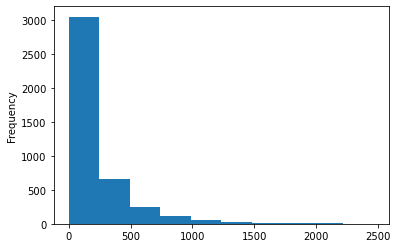

In [160]:
df = indicators[LABEL_FEATURE]
df.plot.hist()

In [161]:
quantiles = []
for i in range(0, 100, 5):
    quantile = df.quantile(i/100)
    quantiles.append(quantile)
    print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))

0% quantile: 0.17
5% quantile: 11.31
10% quantile: 19.85
15% quantile: 29.82
20% quantile: 39.27
25% quantile: 49.97
30% quantile: 61.46
35% quantile: 73.5
40% quantile: 88.38
45% quantile: 101.34
50% quantile: 118.95
55% quantile: 140.37
60% quantile: 164.38
65% quantile: 191.79
70% quantile: 223.34
75% quantile: 266.24
80% quantile: 317.61
85% quantile: 402.86
90% quantile: 537.88
95% quantile: 769.93


In [162]:
def calc_profile(tot_sales, quantiles):
    if (tot_sales < quantiles[10]):
        return "low"
    elif (tot_sales < quantiles[15]):
        return "medium"
    else:
        return "high"

indicators["spending_profile"] = indicators[LABEL_FEATURE].apply(lambda x : calc_profile(x, quantiles))

We drop the column we used to compute our label in order to proceed with classification

In [163]:
indicators = indicators.drop(LABEL_FEATURE, axis=1)

In [164]:
indicators.head()

,Entropy,i,iu,imax,mean_sales,spending_profile
CustomerID,,,,,,
12347,1.945910,2458,103,319,68.744286,high
12348,1.386294,2341,22,1254,44.677500,medium
12350,-0.000000,197,17,197,65.300000,low
12352,2.079442,473,59,98,167.177500,high
12353,-0.000000,20,4,20,24.300000,low


### Discretizing the label

#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

adult = discretize_data(adult, variables)

## Classification with Decision Tree

In [170]:
df = indicators.copy(deep=True)
print(df)

             Entropy     i   iu  imax  mean_sales spending_profile
CustomerID                                                        
12347       1.945910  2458  103   319   68.744286             high
12348       1.386294  2341   22  1254   44.677500           medium
12350      -0.000000   197   17   197   65.300000              low
12352       2.079442   473   59    98  167.177500             high
12353      -0.000000    20    4    20   24.300000              low
...              ...   ...  ...   ...         ...              ...
18280      -0.000000    45   10    45   47.650000              low
18281      -0.000000    54    7    54   39.360000              low
18282       0.693147   103   12    75   31.195000              low
18283       2.566599  1357  263    61   73.395625             high
18287       1.098612  1586   59   488   34.850000              low

[4183 rows x 6 columns]


In [171]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

In [172]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [173]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [174]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [175]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9751315160210425
Accuracy test set  0.9297323135755258
Precision train set  0.975037312051752
Recall train set  0.9751315160210425
F1 score train set  0.9750759596552299
Support train set  (array([0.96545106, 0.99048525, 0.95375723]), array([0.96175908, 0.99617225, 0.94646272]), array([0.96360153, 0.99332061, 0.95009597]), array([ 523, 1045,  523]))


In [176]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["low", "medium", "high"]))

In [177]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       0.91      0.88      0.90       523
      medium       0.98      0.98      0.98      1046
        high       0.85      0.87      0.86       523

    accuracy                           0.93      2092
   macro avg       0.91      0.91      0.91      2092
weighted avg       0.93      0.93      0.93      2092



In [178]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.010712703069051107
Score time  0.004890600840250651
Test score  0.9277857484457198
Train score  0.9703491152558584


In [179]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 460,    0,   63],
       [   0, 1030,   16],
       [  44,   24,  455]])

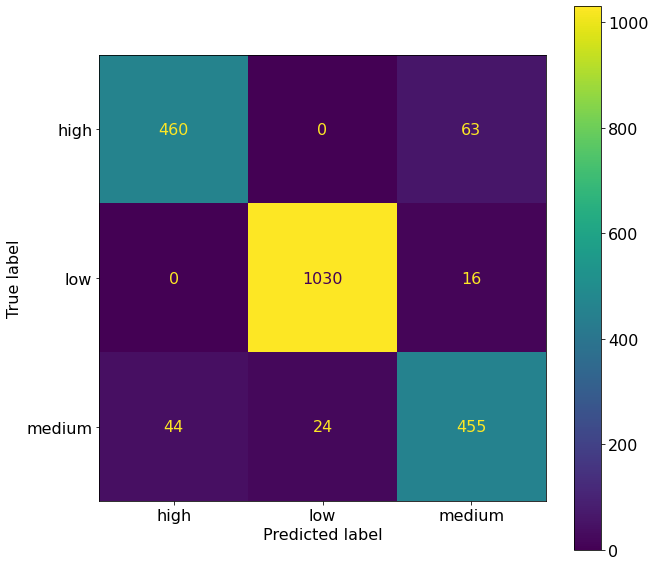

In [187]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16, "axes.labelsize" : 14})


plot_confusion_matrix(dt, test_set, test_label, ax=ax)
plt.show() 

## Classification with Naive Bayes

In [189]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [190]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

         low       0.88      0.70      0.78       523
      medium       0.90      0.91      0.90      1046
        high       0.61      0.73      0.67       523

    accuracy                           0.81      2092
   macro avg       0.80      0.78      0.78      2092
weighted avg       0.82      0.81      0.81      2092

